In [1]:
# Standard library imports
import os
import time

# Third-party imports
import imageio
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import torch
import torch.nn as nn
from IPython import display
from IPython.display import clear_output
from scipy.io import loadmat
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# Local application/library specific imports
from kan import *
import use_KAN
# from use_KAN import *

from use_training_set import *
import yaml

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


## load training sets

In [3]:
config_file = 'setup_ts_full.txt'
x_train, y_train, Q_train = load_training_data(config_file)
parameters_list, SQ_list = load_grid_data(config_file)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)

# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(parameters_list[:,0]-parameters[0])<tol
    id_kappa = np.abs(parameters_list[:,1]-parameters[1])<tol
    id_A = np.abs(parameters_list[:,2]-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [4]:
print(np.unique(parameters_list[:,0]))
print(np.unique(parameters_list[:,1]))
print(np.unique(parameters_list[:,2]))

[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


## load pretrained KAN model

In [5]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)


In [6]:
with open('setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.update_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cuda
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [7]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_9_7_sin_full_ft.pth'))

<All keys matched successfully>

In [8]:
def f_SQ_KAN(model, x, Q=Q):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

def err_L2(x,y):
    index_loss = np.random.randint(95, size=76)
    return np.mean((x[index_loss]-y[index_loss])**2)

In [12]:
Q_test = np.linspace(1.2,20,95)
sq_KAN = f_SQ_KAN(model_KAN, x_train_torch[:100], Q_test)

In [16]:
x_train_torch

tensor([[0.0300, 0.3480, 2.2881],
        [0.0300, 0.3810, 2.5177],
        [0.0310, 0.0700, 3.1916],
        ...,
        [0.4050, 0.4780, 1.7944],
        [0.4050, 0.4800, 2.3145],
        [0.4050, 0.4860, 2.2584]], device='cuda:0')

## visualize KAN

In [13]:
from matplotlib.path import Path
from scipy.interpolate import CubicSpline
from scipy.special import comb

def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """

    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i


def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.

       points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000

        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([ bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)   ])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals

In [28]:
def plot_kan(kan_to_plot, scale = 0.99, color_input = 'r', color_output = 'r', color_f = 'b'):
    width = np.array(kan_to_plot.width)
    width_in = np.array(kan_to_plot.width_in)
    width_out = np.array(kan_to_plot.width_out)
    A = 1
    y0 = 0.3
    z0 = 0.1

    neuron_depth = len(width)
    min_spacing = A / np.maximum(np.max(width_out), 5)

    max_neuron = np.max(width_out)
    max_num_weights = np.max(width_in[:-1] * width_out[1:])
    y1 = 0.4 / np.maximum(max_num_weights, 5)
    y2 = 0.15 / np.maximum(max_neuron, 5)

    fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0 + z0)))

    for l in range(neuron_depth):
        color = 'k'
        if l == 0:
            color = color_input
        if l == neuron_depth - 1:
            color = color_output

        n = width_in[l]

        for i in range(n):
            plt.scatter(1 / (2 * n) + i / n, l * (y0 + z0), s=min_spacing ** 2 * 10000 * scale ** 2, color=color, zorder=20)

        for i in range(n):
            if l < neuron_depth - 1:
                n_next = width_out[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j

                    control_point1 = np.array([1 / (2 * n) + i / n, l * (y0 + z0) + 4 * y0 / 5])
                    control_point2 = np.array([1 / (2 * n_next) + j / n_next, l * (y0 + z0) + y0 / 5])
                    path_data = np.array([
                        (1 / (2 * n) + i / n, l * (y0 + z0)),
                        control_point1,
                        control_point2,
                        (1 / (2 * n_next) + j / n_next, l * (y0 + z0) + y0)
                    ])
                    x, y = bezier_curve(path_data)

                    ax.plot(x, y, color=color_f, lw=1 * scale, alpha=1)

        if l < neuron_depth - 1:
            n_in = width_out[l + 1]
            n_out = width_in[l + 1]
            mult_id = 0
            for i in range(n_in):
                if i < width[l + 1][0]:
                    j = i
                else:
                    if i == width[l + 1][0]:
                        if isinstance(kan2.mult_arity, int):
                            ma = kan_to_plot.mult_arity
                        else:
                            ma = kan_to_plot.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    if current_mult_arity == 0:
                        mult_id += 1
                        if isinstance(kan2.mult_arity, int):
                            ma = kan_to_plot.mult_arity
                        else:
                            ma = kan_to_plot.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    j = width[l + 1][0] + mult_id
                    current_mult_arity -= 1
                plt.plot([1 / (2 * n_in) + i / n_in, 1 / (2 * n_out) + j / n_out], [l * (y0 + z0) + y0, (l + 1) * (y0 + z0)], color='black', lw=2 * scale)
                # Add arrowhead
                arrow_length = 0.02 * scale
                arrow_angle = np.pi / 6
                dx = 1 / (2 * n_out) + j / n_out - (1 / (2 * n_in) + i / n_in)
                dy = (l + 1) * (y0 + z0) - (l * (y0 + z0) + y0)
                angle = np.arctan2(dy, dx)
                x1 = 1 / (2 * n_out) + j / n_out - arrow_length * np.cos(angle - arrow_angle)
                y1 = (l + 1) * (y0 + z0) - arrow_length * np.sin(angle - arrow_angle) - 0.01 * scale
                x2 = 1 / (2 * n_out) + j / n_out - arrow_length * np.cos(angle + arrow_angle)
                y2 = (l + 1) * (y0 + z0) - arrow_length * np.sin(angle + arrow_angle) - 0.01 * scale
                plt.plot([1 / (2 * n_out) + j / n_out, x1], [(l + 1) * (y0 + z0)-0.012, y1], color='black', lw=2 * scale, zorder=100)
                plt.plot([1 / (2 * n_out) + j / n_out, x2], [(l + 1) * (y0 + z0)-0.012, y2], color='black', lw=2 * scale, zorder=100)

            N = n = width_out[l + 1]
            for j in range(n):
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, 'ow', fillstyle='full', ms=15* scale, markeredgewidth=2)
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, 'ok', fillstyle='none', ms=15* scale, markeredgewidth=2)
                plt.plot(1 / (2 * n) + j / n, (l + 1) * (y0 + z0) - z0, '+k', fillstyle='none', ms=12* scale, markeredgewidth=2)

            plt.xlim(0, 1)
            plt.ylim(-0.1 * (y0 + z0), (neuron_depth - 1 + 0.1) * (y0 + z0))
            plt.axis('off')

    plt.show()

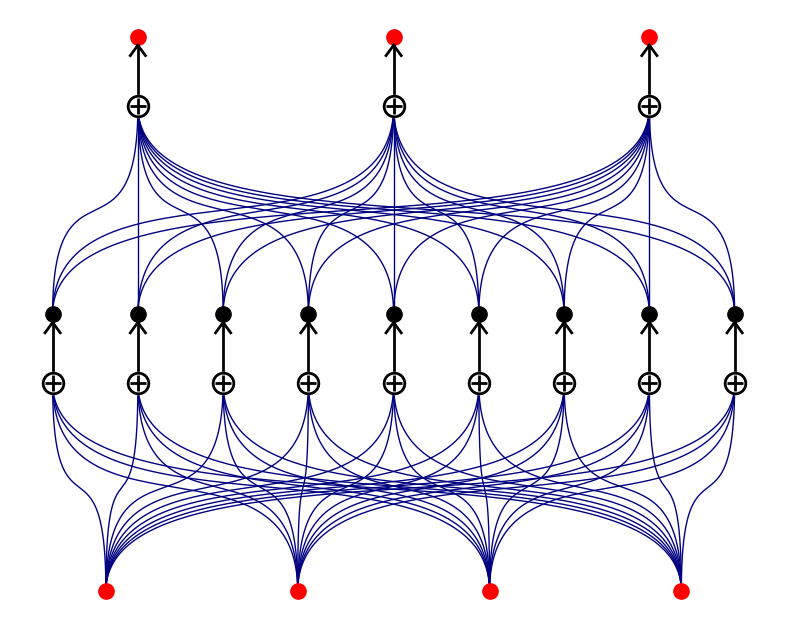

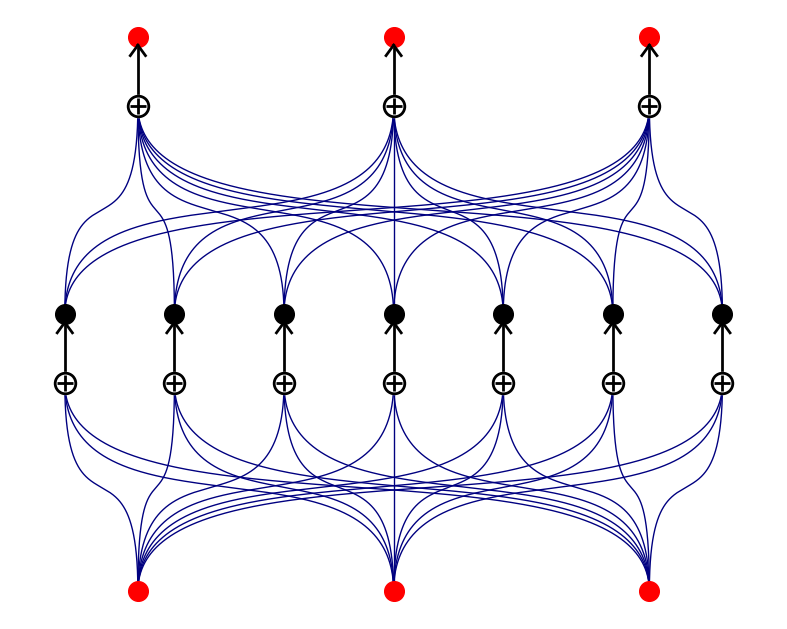

In [29]:
plot_kan(model_KAN.kan, color_f='navy')
plot_kan(model_KAN.kan_aug, color_f='navy')